In [37]:
# imports data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# Загрузка и подготовка датафрейма

In [38]:
# Загружаем инстанс и посмотрим на описание
iris = load_iris()

print('Ключи:\n\t', iris.keys())
print('Признаки:\n\t', iris.feature_names)
print('Таргет:\n\t', list(zip(iris.target_names, np.unique(iris.target) )))

Ключи:
	 dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
Признаки:
	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Таргет:
	 [('setosa', 0), ('versicolor', 1), ('virginica', 2)]


In [39]:
y = iris.target

np.unique(y)

array([0, 1, 2])

In [40]:
# Загрузим данные в табличное представление
df = pd.concat([
                pd.DataFrame(iris.data, columns=iris.feature_names),
                pd.DataFrame(iris.target, columns=['target'])
                ],
                 axis=1
                )
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [41]:
# В данных оставляем только 2 класса: Iris Versicolor, Iris Virginica.
df = df[df['target'] != 0]
df.target.unique()

array([1, 2])

In [42]:
# Представим target в виде бинарной классификации 0 и 1 (Iris Versicolor, Iris Virginica.)
le = LabelEncoder()

le.fit(df.target)
df['target'] = le.fit_transform(df.target)
df.target.unique()

array([0, 1], dtype=int64)

In [43]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [44]:
# Переименуем колонки и посмотрим на подготовленные данные:
df = df.rename(columns={
                        'sepal length (cm)' : 'sepal_length','sepal width (cm)': 'sepal_width',
                        'petal length (cm)': 'petal_length', 'petal width (cm)': 'petal_width',})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [45]:
df.shape

(100, 5)

In [46]:
X = df.drop('target', axis=1)
y = df['target']

In [47]:
# Нормализация данных
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [48]:
# Разобьем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Для начала воспользуемся методом из библиотеки sklearn

In [49]:
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

LogisticRegression()

In [50]:
model_sklearn.intercept_, model_sklearn.coef_

(array([0.04449619]),
 array([[-0.14179521, -0.76305971,  2.09626788,  2.09544343]]))

In [51]:
sklearn_pred = model_sklearn.predict(X_test)

In [52]:
#Посчитаем точность
(sklearn_pred == y_test).mean()

0.9

# Собственная реализация логистической регрессии с помощью градиентного спуска

In [97]:
class MyLogisticRegression:

    def __init__(self, LEARNING_RATE =0.005, max_epoches=2000000, fit_intercept=True, threshold=0.5, EPS= 5e-8, costs=[], gamma=0.9, costs_rms=[]):
        
        self.LEARNING_RATE = LEARNING_RATE
        self.max_epoches = max_epoches
        self.fit_intercept = fit_intercept
        self.threshold = threshold
        self.EPS = EPS
        self.gamma = gamma
        self.costs = costs
        self.costs_rms = costs_rms

   # Внутренние функции для реализации градиентного спуска
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __logg_loss(self, h, y):
        return (-y*np.log(h) - (1-y)*np.log(1-h)).mean()
    

    # Напишем метод градиентного спуска GD
    def fit_GD(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # Инцализация весов. Размерность вектора совпадает с количеством признаков в матрице Х
        self.theta = np.zeros(X.shape[1])

        for epoch in range(self.max_epoches):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.LEARNING_RATE * gradient
            cost = self.__logg_loss(h, y)
            self.costs.append(cost)
  
            try:
                if abs(cost - self.costs[-2]) < self.EPS:
                    print('-'*60)
                    print(f'Модель обучилась за {epoch} эпох') 
                    print(f'Веса модели:{self.theta}')
                    print(f'Итоговая ошибка модели Entropy Log loss:  {cost}')
                    print('-'*60)
                    break
            except:
                pass 

    # Напишем метод оптимизации RMSprop     
    def fit_RMSprop(self, X, y):   
                
        if self.fit_intercept:
            X = self.__add_intercept(X)

        #Сгенерируем веса  
        self.theta  = np.zeros(X.shape[1])
        self.cache  = np.zeros(X.shape[1])
        
        for epoch in range(self.max_epoches):
            
            # Рассчитаем сигнал через функцию активации sigmoid 
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            # Вычислим кросс-этропийную ошибку при текущих весах           
            loss = - np.mean(np.log(h) * y + np.log(1 - h) * (1 - y))
            self.costs_rms.append(loss)
            
            #  Вычислим градиент в сторону, которого мы будем делать шаг обучения    
            grad = np.dot(X.T, (h - y)) / y.size  
            
            # Обновим веса в сторону рассчитанного антиградиента
            self.cache = self.gamma * self.cache + (1 - self.gamma) * grad ** 2
            self.theta -= self.LEARNING_RATE * grad / (np.sqrt(self.cache) + 1e-8)
          
            #  Рассчитаем потерю logg loss на текущей эпохе обучения и запишем ее в список   
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            cost_rms = self.__logg_loss(h, y)
            self.costs.append(cost_rms)
#             print(f' Эпоха обучения: {epoch} ---> log loss: {cost_rms}')
        
        #   Условие остановки, при котором будем считать, что модель обучилась.      
            try:
                if abs(cost_rms - self.costs_rms[-2]) < self.EPS:
                    print('-'*60)
                    print(f'Модель обучилась за {epoch} эпох') 
                    print(f'Веса модели:{self.cache}')
                    print(f'Итоговая ошибка модели Entropy Log loss:  {cost_rms}')
                    print('-'*60)
                    break
            except:
                pass 

    

    # Функции для оценки качества модели

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold

    
    def accuracy_score(self, X):
        return (self.predict(X) == y).mean()


# Обучение и оценка качества модели

In [19]:
# Создаю инстанс собственного класса логистической регрессии

model_gd = MyLogisticRegression(LEARNING_RATE=1e-3, EPS= 1e-6)

In [20]:
# Посмотрим как падает ошибка в процессе градиентного спуска
model_gd.fit_GD(X_train, y_train)

------------------------------------------------------------
Модель обучилась за 44406 эпох
Веса модели:[ 0.04111118 -0.1089796  -0.89938285  2.32914941  2.5282901 ]
Итоговая ошибка модели Entropy Log loss:  0.07366717312742539
------------------------------------------------------------


In [21]:
loss_gd = model_gd.costs

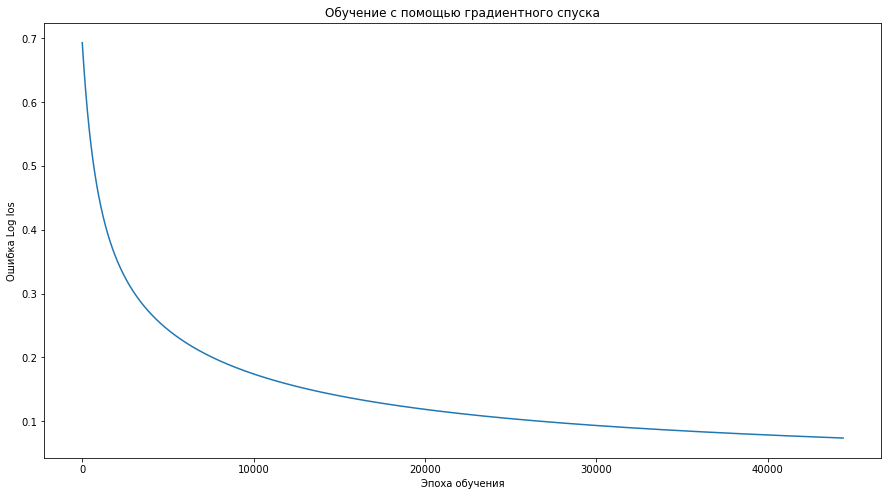

In [22]:
# Постриом график, как изменялась ошибка в процессе обучения модели
plt.figure(figsize= (15, 8))
plt.plot(loss_gd)
plt.title('Обучение с помощью градиентного спуска')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка Log los')
plt.show()

In [23]:
# Качество алгоритма
y_pred = model_gd.predict(X)
score = (y_pred == y).mean()
print(f'Метрика качества accuracy: {score}')

Метрика качества accuracy: 0.97


# RMS prop

In [92]:
model_RMSpro = MyLogisticRegression(LEARNING_RATE=1e-3, EPS= 1e-6)

In [93]:
model_RMSpro.fit_RMSprop(X_train, y_train)

C:\Users\Alex\AppData\Local\Temp/ipykernel_17920/2459089527.py:23: RuntimeWarning: divide by zero encountered in log
  return (-y*np.log(h) - (1-y)*np.log(1-h)).mean()
C:\Users\Alex\AppData\Local\Temp/ipykernel_17920/2459089527.py:70: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(np.log(h) * y + np.log(1 - h) * (1 - y))


------------------------------------------------------------
Модель обучилась за 12523 эпох
Веса модели:[1.86590169e-12 1.02684448e-12 1.27634984e-12 1.26443203e-07
 1.95199221e-08]
Итоговая ошибка модели Entropy Log loss:  0.0015993612930217823
------------------------------------------------------------


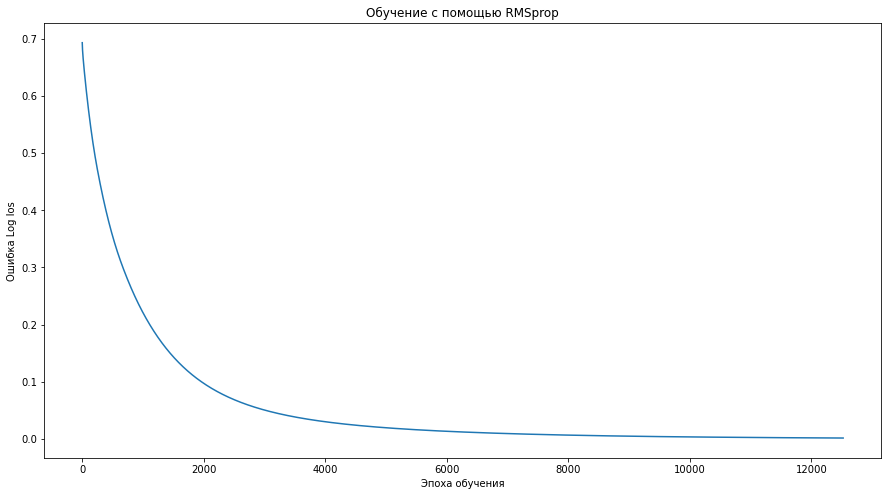

In [94]:
loss_RMSprop = model_RMSpro.costs_rms

# Постриом график, как изменялась ошибка в процессе обучения модели
plt.figure(figsize= (15, 8))
plt.plot(loss_RMSprop)
plt.title('Обучение с помощью RMSprop')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка Log los')
plt.show()

In [96]:
# Проверим метрику качества Accuracy на отложенной тестовой выборке:

y_pred_rms = model_RMSpro.predict(X_test)

score = (y_pred_rms == y_test).mean()
print(f'Метрика качества accuracy: {score}')

Метрика качества accuracy: 0.8333333333333334
